Since the last notebook got super messy....... let's start with defining some functions so things are cleaner jeez

I'm gonna run some models and do the metrics on them here

In [17]:
#imports
import uproot as ur
import awkward as ak
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2" #specify GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import graph_util as gu
import plot_util as pu

from scipy.interpolate import interp1d

In [2]:
data_path = '/fast_scratch/atlas_images/v01-45/' 
file = np.load(data_path+'nn_splitdata_w7_2.npz')

In [3]:
X_train = file['arr_0']
X_val = file['arr_1']
X_test = file['arr_2']
Y_train = file['arr_3']
Y_val = file['arr_4']
Y_test = file['arr_5']
eta_train = file['arr_6']
eta_val = file['arr_7']
eta_test = file['arr_8']
ET_train = file['arr_9']
ET_val = file['arr_10']
ET_test = file['arr_11']
Pt_train = file['arr_12']
Pt_val = file['arr_13']
Pt_test = file['arr_14']
Eng_train = file['arr_15']
Eng_val = file['arr_16']
Eng_test = file['arr_17']

In [4]:
#first run a model with only eta and Pt as global vars
X_glob_train_1 = np.stack((np.array(eta_train), np.array(Pt_train)), axis=1)
X_glob_vali_1 = np.stack((np.array(eta_val), np.array(Pt_val)), axis=1)
X_glob_test_1 = np.stack((np.array(eta_test), np.array(Pt_test)), axis=1)

In [5]:
#later one with eta and E
X_glob_train_2 = np.stack((np.array(eta_train), np.array(Eng_train)), axis=1)
X_glob_vali_2 = np.stack((np.array(eta_val), np.array(Eng_val)), axis=1)
X_glob_test_2 = np.stack((np.array(eta_test), np.array(Eng_test)), axis=1)

In [28]:
#this is the model with the three global params
model3g = tf.keras.models.load_model(data_path+'w7_pfn_global.hdf5')

#this is the no global params model
model_nog = tf.keras.models.load_model(data_path+'w6_pfn_noglob.hdf5')

#now I've made a model with Pt and eta only
model_pt = tf.keras.models.load_model(data_path+'w7_pfn_global_etapt.hdf5')

#...and one with E and eta only
model_E = tf.keras.models.load_model(data_path+'w7_pfn_global_etaE.hdf5')

In [6]:
def GlobalModel(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_tr, X_glob_val, X_glob_te, epochs, batch_size, num_glob, filename):
    #for now, try all three global features in X_glob okay?! 
    #one function to run the model & create the metrics
    
    Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
   
    #concatenate the Xs (needed for global features):
    X_tr = [X_train, X_glob_tr] #will this work?
    X_vali = [X_val, X_glob_val]
    X_te = [X_test, X_glob_te]
    
    #make the model:
    pfn = PFN(input_dim=X_train.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, num_global_features =num_glob)
    
    #try callbacks:
    callback = tf.keras.callbacks.ModelCheckpoint(data_path+filename, save_best_only=True)
    
    # train model
    history = pfn.fit(X_tr, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_vali, Y_val), verbose=1, callbacks=[callback])
   
    return history

In [8]:
hist1 = GlobalModel(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_train_1, X_glob_vali_1, X_glob_test_1, 100, 1000, 2, 'w7_pfn_global_etapt.hdf5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [22]:
hist2 = GlobalModel(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_train_2, X_glob_vali_2, X_glob_test_2, 100, 1000, 2, 'w7_pfn_global_etaE.hdf5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
____________________________________________________________________________________________

In [12]:
def metrics(model, X_te, X_globte, select):
    #make metrics
    X_1, X_2 = X_te, X_globte
    fps = []
    tps = []
    threshss = []
    aucs = []
    for selection in select:
        X_interm = [X_1[selection], X_2[selection]] #YAY got it working!! just had to split it up to make the selection
        preds = model.predict(X_interm, batch_size=1000) 
        pfn_fp, pfn_tp, threshs = roc_curve(Y_test[selection][:,1], preds[:,1])
        
        fps.append(pfn_fp)
        tps.append(pfn_tp)
        threshss.append(threshs)
        
        # get area under the ROC curve
        auc = roc_auc_score(Y_test[selection][:,1], preds[:,1])
        aucs.append(auc)
        print('PFN AUC:', auc)
        
    return fps, tps, aucs

In [35]:
def interp95(fps, tps):
    fg = []
    for i in range(len(fps)):
        fg.append(interp1d(tps[i], 1/fps[i]))

    reg95 = []
    for i in range(len(fg)):
        reg95.append(fg[i](.95))
    return reg95

In [70]:
def plots1(ranges, aucs, aucs_ng, reg95, reg95_ng, rangename='eta', globalpars='eta, Pt, E', logx=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,6])
    if logx:
        ax1.semilogx()
    ax1.set_xlim(0., max(ranges)+.1)
    ax1.plot(ranges, aucs, linewidth=3, c='xkcd:sandstone', marker='o', label='global '+globalpars)
    ax1.plot(ranges, aucs_ng, linewidth=3, c='xkcd:macaroni and cheese', marker='o', label='no global features')
    ax1.set_xlabel('absolute range in '+rangename)
    ax1.set_ylabel('AUC')
    ax1.legend()
    
    if logx:
        ax2.semilogx()
    ax2.set_xlim(0., max(ranges)+.1)
    ax2.plot(ranges, reg95, linewidth=3, c='xkcd:dark sand', marker='o', label='global '+globalpars)
    ax2.plot(ranges, reg95_ng, linewidth=3, c='xkcd:pale peach', marker='o', label='no global features')
    ax2.set_xlabel('absolute range in '+rangename)
    ax2.set_ylabel('Rejection at 95% efficiency')
    ax2.legend()

In [15]:
# define ranges and selections in eta

eta_ranges = np.arange(0., 3.1, .1)+.05

selec_01 = abs(eta_test) < 0.1
selec_02 = (abs(eta_test) >= .1) & (abs(eta_test) < .2)
selec_03 = (abs(eta_test) >= .2) & (abs(eta_test) < .3)
selec_04 = (abs(eta_test) >= .3) & (abs(eta_test) < .4)
selec_05 = (abs(eta_test) >= .4) & (abs(eta_test) < .5)
selec_06 = (abs(eta_test) >= .5) & (abs(eta_test) < .6)
selec_07 = (abs(eta_test) >= .6) & (abs(eta_test) < .7)
selec_08 = (abs(eta_test) >= .7) & (abs(eta_test) < .8)
selec_09 = (abs(eta_test) >= .8) & (abs(eta_test) < .9)
selec_10 = (abs(eta_test) >= .9) & (abs(eta_test) < 1.)
selec_11 = (abs(eta_test) >= 1.) & (abs(eta_test) < 1.1)
selec_12 = (abs(eta_test) >= 1.1) & (abs(eta_test) < 1.2)
selec_13 = (abs(eta_test) >= 1.2) & (abs(eta_test) < 1.3)
selec_14 = (abs(eta_test) >= 1.3) & (abs(eta_test) < 1.4)
selec_15 = (abs(eta_test) >= 1.4) & (abs(eta_test) < 1.5)
selec_16 = (abs(eta_test) >= 1.5) & (abs(eta_test) < 1.6)
selec_17 = (abs(eta_test) >= 1.6) & (abs(eta_test) < 1.7)
selec_18 = (abs(eta_test) >= 1.7) & (abs(eta_test) < 1.8)
selec_19 = (abs(eta_test) >= 1.8) & (abs(eta_test) < 1.9)
selec_20 = (abs(eta_test) >= 1.9) & (abs(eta_test) < 2.)
selec_21 = (abs(eta_test) >= 2.) & (abs(eta_test) < 2.1)
selec_22 = (abs(eta_test) >= 2.1) & (abs(eta_test) < 2.2)
selec_23 = (abs(eta_test) >= 2.2) & (abs(eta_test) < 2.3)
selec_24 = (abs(eta_test) >= 2.3) & (abs(eta_test) < 2.4)
selec_25 = (abs(eta_test) >= 2.4) & (abs(eta_test) < 2.5)
selec_26 = (abs(eta_test) >= 2.5) & (abs(eta_test) < 2.6)
selec_27 = (abs(eta_test) >= 2.6) & (abs(eta_test) < 2.7)
selec_28 = (abs(eta_test) >= 2.7) & (abs(eta_test) < 2.8)
selec_29 = (abs(eta_test) >= 2.8) & (abs(eta_test) < 2.9)
selec_30 = (abs(eta_test) >= 2.9) & (abs(eta_test) < 3.)
selec_all = abs(eta_test) <= 3. 

eta_sel = [selec_01, selec_02, selec_03, selec_04, selec_05, selec_06, selec_07, selec_08, selec_09, selec_10,
              selec_11, selec_12, selec_13, selec_14, selec_15, selec_16, selec_17, selec_18, selec_19, selec_20,
              selec_21, selec_22, selec_23, selec_24, selec_25, selec_26, selec_27, selec_28, selec_29, selec_30,
              selec_all]

In [24]:
#define ranges and selections in ET:

ET_range = np.logspace(np.log10(min(ET_test)), np.log10(max(ET_test)+1), 30)

ET_sel = [abs(ET_test) < ET_range[1]]
for i in range(1, len(ET_range)):
    selec_ = (abs(ET_test) >= ET_range[i-1]) & (abs(ET_test) < ET_range[i])
    ET_sel.append(selec_)

ET_sel.append(abs(ET_test) < ET_range[-1]+1)


In [25]:
#define ranges and selections in Pt:

Pt_range = np.logspace(np.log10(min(Pt_test)), np.log10(max(Pt_test)+1), 30)

Pt_sel = [abs(Pt_test) < Pt_range[1]]
for i in range(1, len(Pt_range)):
    selec_ = (abs(Pt_test) >= Pt_range[i-1]) & (abs(Pt_test) < Pt_range[i])
    Pt_sel.append(selec_)

Pt_sel.append(abs(Pt_test) < Pt_range[-1]+1)


In [29]:
#define ranges and selections in E:

E_range = np.logspace(np.log10(min(Eng_test)), np.log10(max(Eng_test)+1), 30)

E_sel = [abs(Eng_test) < E_range[1]]
for i in range(1, len(E_range)):
    selec_ = (abs(Eng_test) >= E_range[i-1]) & (abs(Eng_test) < E_range[i])
    E_sel.append(selec_)

E_sel.append(abs(Eng_test) < E_range[-1]+1)


In [59]:
#define AUC plotting function that is wary of the type of data its using... but lets have all the selections be 
#the same length as eta_sel so 31

def plothelper(ax, labs, fps, tps, aucs, col, fps_all, tps_all, aucs_all):
    ax.set_xlim(0.,.2)
    ax.set_ylim(.8,1.)
    ax.plot([0, 1], [0, 1], 'k--')
    for i in range(len(labs)):
        ax.plot(fps[i], tps[i], c=col[i], linewidth=3, label=labs[i] + ' AUC = %.3f '%aucs[i])
    ax.plot(fps_all, tps_all, c='b', label='all'+' AUC = %.3f '%aucs_all)
    ax.set_ylabel('True positive rate')
    ax.set_xlabel('False positive rate')
    ax.legend() 

In [21]:
print('%.3f <= $\eta$ < %.3f'%(eta_test[0], eta_test[1]))

-0.508 <= $\eta$ < -1.817


In [74]:
def AUCplot(rang, fps, tps, auc, rangetype='eta'):
    #rangetype can be 'eta', 'E_T', 'E', or 'Pt'
    if rangetype == 'eta':
        labs1 = ['$\eta$ < .1', '.1 <= $\eta$ < .2', '.2 <= $\eta$ < .3','.3 <= $\eta$ < .4','.4 <= $\eta$ < .5']
        labs2 = ['.5 <= $\eta$ < .6','.6 <= $\eta$ < .7','.7 <= $\eta$ < .8','.8 <= $\eta$ < .9','.9 <= $\eta$ < 1.']
        labs3 = ['1. <= $\eta$ < 1.1','1.1 <= $\eta$ < 1.2','1.2 <= $\eta$ < 1.3','1.3 <= $\eta$ < 1.4','1.4 <= $\eta$ < 1.5']
        labs4 = ['1.5 <= $\eta$ < 1.6','1.6 <= $\eta$ < 1.7','1.7 <= $\eta$ < 1.8','1.8 <= $\eta$ < 1.9','1.9 <= $\eta$ < 2']
        labs5 = ['2. <= $\eta$ < 2.1','2.1 <= $\eta$ < 2.2','2.2 <= $\eta$ < 2.3','2.3 <= $\eta$ < 2.4','2.4 <= $\eta$ < 2.5']
        labs6 = ['2.5 <= $\eta$ < 2.6','2.6 <= $\eta$ < 2.7','2.7 <= $\eta$ < 2.8','2.8 <= $\eta$ < 2.9','2.9 <= $\eta$ < 3.']
    elif rangetype=='E_T':
        labs1 = ['$E_T$ < %.3f'%rang[0], '%.3f <= $E_T$ < %.3f'%(rang[0], rang[1]), '%.3f <= $E_T$ < %.3f'%(rang[1], rang[2]),'%.3f <= $E_T$ < %.3f'%(rang[2], rang[3]),'%.3f <= $E_T$ < %.3f'%(rang[3], rang[4])]
        labs2 = ['%.3f <= $E_T$ < %.3f'%(rang[4], rang[5]), '%.3f <= $E_T$ < %.3f'%(rang[5], rang[6]), '%.3f <= $E_T$ < %.3f'%(rang[6], rang[7]),'%.3f <= $E_T$ < %.3f'%(rang[7], rang[8]),'%.3f <= $E_T$ < %.3f'%(rang[8], rang[9])]
        labs3 = ['%.3f <= $E_T$ < %.3f'%(rang[9], rang[10]), '%.3f <= $E_T$ < %.3f'%(rang[10], rang[11]), '%.3f <= $E_T$ < %.3f'%(rang[11], rang[12]),'%.3f <= $E_T$ < %.3f'%(rang[12], rang[13]),'%.3f <= $E_T$ < %.3f'%(rang[13], rang[14])]
        labs4 = ['%.3f <= $E_T$ < %.3f'%(rang[14], rang[15]), '%.3f <= $E_T$ < %.3f'%(rang[15], rang[16]), '%.3f <= $E_T$ < %.3f'%(rang[16], rang[17]),'%.3f <= $E_T$ < %.3f'%(rang[17], rang[18]),'%.3f <= $E_T$ < %.3f'%(rang[18], rang[19])]
        labs5 = ['%.3f <= $E_T$ < %.3f'%(rang[19], rang[20]), '%.3f <= $E_T$ < %.3f'%(rang[20], rang[21]), '%.3f <= $E_T$ < %.3f'%(rang[21], rang[22]),'%.3f <= $E_T$ < %.3f'%(rang[22], rang[23]),'%.3f <= $E_T$ < %.3f'%(rang[23], rang[24])]
        labs6 = ['%.3f <= $E_T$ < %.3f'%(rang[24], rang[25]), '%.3f <= $E_T$ < %.3f'%(rang[25], rang[26]), '%.3f <= $E_T$ < %.3f'%(rang[26], rang[27]),'%.3f <= $E_T$ < %.3f'%(rang[27], rang[28]),'%.3f <= $E_T$ < %.3f'%(rang[28], rang[29])]
  
    elif rangetype=='Pt':
        labs1 = ['$p_T$ < %.3f'%rang[0], '%.3f <= $p_T$ < %.3f'%(rang[0], rang[1]), '%.3f <= $p_T$ < %.3f'%(rang[1], rang[2]),'%.3f <= $p_T$ < %.3f'%(rang[2], rang[3]),'%.3f <= $p_T$ < %.3f'%(rang[3], rang[4])]
        labs2 = ['%.3f <= $p_T$ < %.3f'%(rang[4], rang[5]), '%.3f <= $p_T$ < %.3f'%(rang[5], rang[6]), '%.3f <= $p_T$ < %.3f'%(rang[6], rang[7]),'%.3f <= $p_T$ < %.3f'%(rang[7], rang[8]),'%.3f <= $p_T$ < %.3f'%(rang[8], rang[9])]
        labs3 = ['%.3f <= $p_T$ < %.3f'%(rang[9], rang[10]), '%.3f <= $p_T$ < %.3f'%(rang[10], rang[11]), '%.3f <= $p_T$ < %.3f'%(rang[11], rang[12]),'%.3f <= $p_T$ < %.3f'%(rang[12], rang[13]),'%.3f <= $p_T$ < %.3f'%(rang[13], rang[14])]
        labs4 = ['%.3f <= $p_T$ < %.3f'%(rang[14], rang[15]), '%.3f <= $p_T$ < %.3f'%(rang[15], rang[16]), '%.3f <= $p_T$ < %.3f'%(rang[16], rang[17]),'%.3f <= $p_T$ < %.3f'%(rang[17], rang[18]),'%.3f <= $p_T$ < %.3f'%(rang[18], rang[19])]
        labs5 = ['%.3f <= $p_T$ < %.3f'%(rang[19], rang[20]), '%.3f <= $p_T$ < %.3f'%(rang[20], rang[21]), '%.3f <= $p_T$ < %.3f'%(rang[21], rang[22]),'%.3f <= $p_T$ < %.3f'%(rang[22], rang[23]),'%.3f <= $p_T$ < %.3f'%(rang[23], rang[24])]
        labs6 = ['%.3f <= $p_T$ < %.3f'%(rang[24], rang[25]), '%.3f <= $p_T$ < %.3f'%(rang[25], rang[26]), '%.3f <= $p_T$ < %.3f'%(rang[26], rang[27]),'%.3f <= $p_T$ < %.3f'%(rang[27], rang[28]),'%.3f <= $p_T$ < %.3f'%(rang[28], rang[29])]
  
    elif rangetype=='E':
        labs1 = ['$E$ < %.3f'%rang[0], '%.3f <= $E$ < %.3f'%(rang[0], rang[1]), '%.3f <= $E$ < %.3f'%(rang[1], rang[2]),'%.3f <= $E$ < %.3f'%(rang[2], rang[3]),'%.3f <= $E$ < %.3f'%(rang[3], rang[4])]
        labs2 = ['%.3f <= $E$ < %.3f'%(rang[4], rang[5]), '%.3f <= $E$ < %.3f'%(rang[5], rang[6]), '%.3f <= $E$ < %.3f'%(rang[6], rang[7]),'%.3f <= $E$ < %.3f'%(rang[7], rang[8]),'%.3f <= $E$ < %.3f'%(rang[8], rang[9])]
        labs3 = ['%.3f <= $E$ < %.3f'%(rang[9], rang[10]), '%.3f <= $E$ < %.3f'%(rang[10], rang[11]), '%.3f <= $E$ < %.3f'%(rang[11], rang[12]),'%.3f <= $E$ < %.3f'%(rang[12], rang[13]),'%.3f <= $E$ < %.3f'%(rang[13], rang[14])]
        labs4 = ['%.3f <= $E$ < %.3f'%(rang[14], rang[15]), '%.3f <= $E$ < %.3f'%(rang[15], rang[16]), '%.3f <= $E$ < %.3f'%(rang[16], rang[17]),'%.3f <= $E$ < %.3f'%(rang[17], rang[18]),'%.3f <= $E$ < %.3f'%(rang[18], rang[19])]
        labs5 = ['%.3f <= $E$ < %.3f'%(rang[19], rang[20]), '%.3f <= $E$ < %.3f'%(rang[20], rang[21]), '%.3f <= $E$ < %.3f'%(rang[21], rang[22]),'%.3f <= $E$ < %.3f'%(rang[22], rang[23]),'%.3f <= $E$ < %.3f'%(rang[23], rang[24])]
        labs6 = ['%.3f <= $E$ < %.3f'%(rang[24], rang[25]), '%.3f <= $E$ < %.3f'%(rang[25], rang[26]), '%.3f <= $E$ < %.3f'%(rang[26], rang[27]),'%.3f <= $E$ < %.3f'%(rang[27], rang[28]),'%.3f <= $E$ < %.3f'%(rang[28], rang[29])]
  
    else:
        print('you broke it')
        
        
    col = ['xkcd:poo brown', 'xkcd:amber', 'xkcd:sandy brown', 'xkcd:grey brown', 'xkcd:pale peach']
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=[24,16])

    plothelper(ax1, labs1, fps[:5], tps[:5], auc[:5], col, fps[-1], tps[-1], auc[-1])
    plothelper(ax2, labs2, fps[5:10], tps[5:10], auc[5:10], col, fps[-1], tps[-1], auc[-1])
    plothelper(ax3, labs3, fps[10:15], tps[10:15], auc[10:15], col, fps[-1], tps[-1], auc[-1])
    plothelper(ax4, labs4, fps[15:20], tps[15:20], auc[15:20], col, fps[-1], tps[-1], auc[-1])
    plothelper(ax5, labs5, fps[20:25], tps[20:25], auc[20:25], col, fps[-1], tps[-1], auc[-1])
    plothelper(ax6, labs6, fps[25:30], tps[25:30], auc[25:30], col, fps[-1], tps[-1], auc[-1])
    plt.savefig('./'+rangetype+'_ranges_AUCs')

In [31]:
#make metrics for the no global model, these will be universal
def metrics_ng(X_test, selections):

    fps_ng = []
    tps_ng = []
    aucs_ng = []
    for selection in selections:
        preds = model_nog.predict(X_test[selection], batch_size=1000) 
        pfn_fp, pfn_tp, threshs = roc_curve(Y_test[selection][:,1], preds[:,1])

        fps_ng.append(pfn_fp)
        tps_ng.append(pfn_tp)

        # get area under the ROC curve
        auc = roc_auc_score(Y_test[selection][:,1], preds[:,1])
        aucs_ng.append(auc)
        print('PFN AUC:', auc)
    return fps_ng, tps_ng, aucs_ng

In [32]:
#get all the metrics for the no global features model!
fps_ng_eta, tps_ng_eta, auc_ng_eta = metrics_ng(X_test, eta_sel)
fps_ng_pt, tps_ng_pt, auc_ng_pt = metrics_ng(X_test, Pt_sel)
fps_ng_ET, tps_ng_ET, auc_ng_ET = metrics_ng(X_test, ET_sel)
fps_ng_E, tps_ng_E, auc_ng_E = metrics_ng(X_test, E_sel)

PFN AUC: 0.9778651898737227
PFN AUC: 0.9783127095508898
PFN AUC: 0.9776603622078399
PFN AUC: 0.9797812820026444
PFN AUC: 0.979449381589349
PFN AUC: 0.9785590837379706
PFN AUC: 0.9805161425799649
PFN AUC: 0.9776134554379604
PFN AUC: 0.9767846423784298
PFN AUC: 0.97542219985448
PFN AUC: 0.9779614342721266
PFN AUC: 0.9767863514700542
PFN AUC: 0.9736458480094845
PFN AUC: 0.9621387107755552
PFN AUC: 0.9237134964483031
PFN AUC: 0.9275204564957995
PFN AUC: 0.9486568258249932
PFN AUC: 0.9373450913801015
PFN AUC: 0.9365177841699127
PFN AUC: 0.9383653817384383
PFN AUC: 0.9454547182413561
PFN AUC: 0.9543738511224573
PFN AUC: 0.9509423733142741
PFN AUC: 0.9569621811144445
PFN AUC: 0.9503345998203652
PFN AUC: 0.9681950290147777
PFN AUC: 0.9853137145237781
PFN AUC: 0.9845395528386605
PFN AUC: 0.9850872151952879
PFN AUC: 0.9890729055997511
PFN AUC: 0.9649076352864245
PFN AUC: 0.8293650793650793
PFN AUC: 0.8293650793650793
PFN AUC: 0.8685078756917838
PFN AUC: 0.8339468690702088
PFN AUC: 0.824949069892

In [33]:
fps_pt_eta, tps_pt_eta, auc_pt_eta = metrics(model_pt, X_test, X_glob_test_1, eta_sel)
fps_pt_pt, tps_pt_pt, auc_pt_pt = metrics(model_pt, X_test, X_glob_test_1, Pt_sel)
fps_pt_ET, tps_pt_ET, auc_pt_ET = metrics(model_pt, X_test, X_glob_test_1, ET_sel)
fps_pt_E, tps_pt_E, auc_pt_E = metrics(model_pt, X_test, X_glob_test_1, E_sel)

PFN AUC: 0.9770932036392604
PFN AUC: 0.97781417817662
PFN AUC: 0.9772016035492631
PFN AUC: 0.9788309025461936
PFN AUC: 0.978769026424127
PFN AUC: 0.9775584474448946
PFN AUC: 0.9792104273121082
PFN AUC: 0.9759010797449894
PFN AUC: 0.9757648865110284
PFN AUC: 0.9740472534106916
PFN AUC: 0.9760841817663802
PFN AUC: 0.975641350751718
PFN AUC: 0.9720138485593033
PFN AUC: 0.9593381074301401
PFN AUC: 0.9163476125613318
PFN AUC: 0.9251909035705794
PFN AUC: 0.9478169764036455
PFN AUC: 0.934028284723797
PFN AUC: 0.9333524910075481
PFN AUC: 0.9375939521389619
PFN AUC: 0.9450515462993261
PFN AUC: 0.9531282202210845
PFN AUC: 0.9497037234373447
PFN AUC: 0.9556205236585653
PFN AUC: 0.9500183518456324
PFN AUC: 0.9597288154280784
PFN AUC: 0.9803928422638581
PFN AUC: 0.979488572657318
PFN AUC: 0.9812251135871213
PFN AUC: 0.9846586639371874
PFN AUC: 0.9631786561835016
PFN AUC: 0.8690476190476191
PFN AUC: 0.8690476190476191
PFN AUC: 0.8619625372498936
PFN AUC: 0.813899430740038
PFN AUC: 0.8209897326792983

In [34]:
fps_E_eta, tps_E_eta, auc_E_eta = metrics(model_E, X_test, X_glob_test_2, eta_sel)
fps_E_pt, tps_E_pt, auc_E_pt = metrics(model_E, X_test, X_glob_test_2, Pt_sel)
fps_E_ET, tps_E_ET, auc_E_ET = metrics(model_E, X_test, X_glob_test_2, ET_sel)
fps_E_E, tps_E_E, auc_E_E = metrics(model_E, X_test, X_glob_test_2, E_sel)

PFN AUC: 0.9773331029759952
PFN AUC: 0.9777971429819077
PFN AUC: 0.977735283528131
PFN AUC: 0.9795678615062295
PFN AUC: 0.9786876766453152
PFN AUC: 0.9769499919241202
PFN AUC: 0.9780293085285513
PFN AUC: 0.9759102703439757
PFN AUC: 0.9757428369219543
PFN AUC: 0.9734432283472156
PFN AUC: 0.9760514139344602
PFN AUC: 0.9736992374049078
PFN AUC: 0.9722456487001943
PFN AUC: 0.9584240329861572
PFN AUC: 0.9160647361778431
PFN AUC: 0.9235671738432393
PFN AUC: 0.9487155753106109
PFN AUC: 0.933625459870769
PFN AUC: 0.9313175682636528
PFN AUC: 0.9362607764457538
PFN AUC: 0.943609182314944
PFN AUC: 0.9522917619790078
PFN AUC: 0.9495149420488598
PFN AUC: 0.9541245096014868
PFN AUC: 0.9470914375922378
PFN AUC: 0.9593739853237224
PFN AUC: 0.9805672628593278
PFN AUC: 0.9789498227703797
PFN AUC: 0.9827865296739962
PFN AUC: 0.9843634202275141
PFN AUC: 0.9626517492844407
PFN AUC: 0.8174603174603174
PFN AUC: 0.8174603174603174
PFN AUC: 0.8569071945508726
PFN AUC: 0.8177628083491462
PFN AUC: 0.825970854203

In [41]:
reg95_ng_eta = interp95(fps_ng_eta, tps_ng_eta)
reg95_ng_Pt = interp95(fps_ng_pt, tps_ng_pt)
reg95_ng_ET = interp95(fps_ng_ET, tps_ng_ET)
reg95_ng_E = interp95(fps_ng_E, tps_ng_E)

reg95_pt_eta = interp95(fps_pt_eta, tps_pt_eta)
reg95_pt_Pt = interp95(fps_pt_pt, tps_pt_pt)
reg95_pt_ET = interp95(fps_pt_ET, tps_pt_ET)
reg95_pt_E = interp95(fps_pt_E, tps_pt_E)

reg95_E_eta = interp95(fps_E_eta, tps_E_eta)
reg95_E_Pt = interp95(fps_E_pt, tps_E_pt)
reg95_E_ET = interp95(fps_E_ET, tps_E_ET)
reg95_E_E = interp95(fps_E_E, tps_E_E)

<ipython-input-35-b165a60b5f60>:4: RuntimeWarning: divide by zero encountered in true_divide
  fg.append(interp1d(tps[i], 1/fps[i]))


In [ ]:
#finally onto the results: start with the Pt one

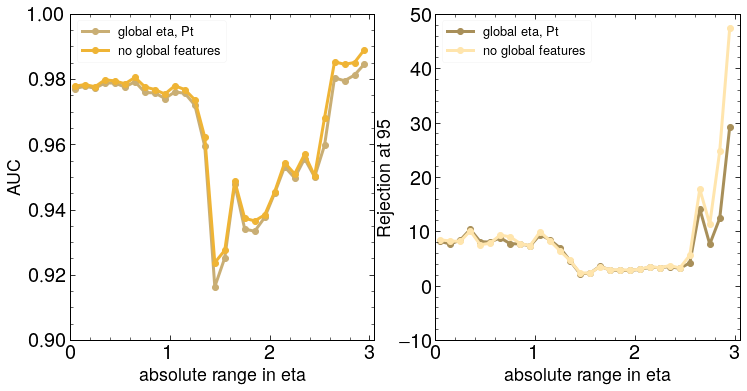

In [71]:
plots1(eta_ranges[:-1], auc_pt_eta[:-1], auc_ng_eta[:-1], reg95_pt_eta[:-1], reg95_ng_eta[:-1], rangename='eta', globalpars='eta, Pt')

<ipython-input-70-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)


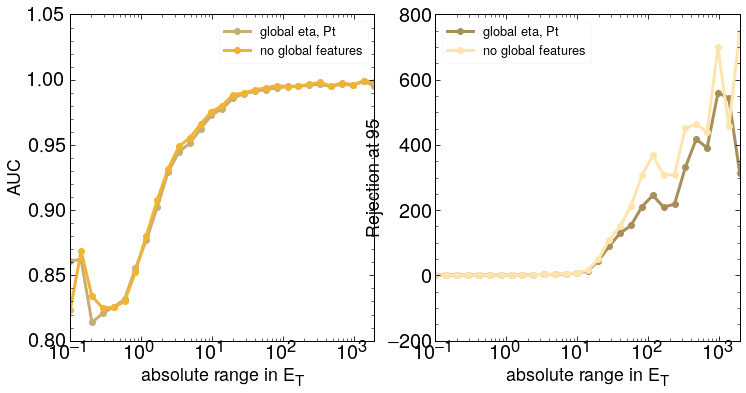

In [72]:
plots1(ET_range, auc_pt_ET[:-1], auc_ng_ET[:-1], reg95_pt_ET[:-1], reg95_ng_ET[:-1], rangename='$E_T$', globalpars='eta, Pt', logx=True)

<ipython-input-70-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)


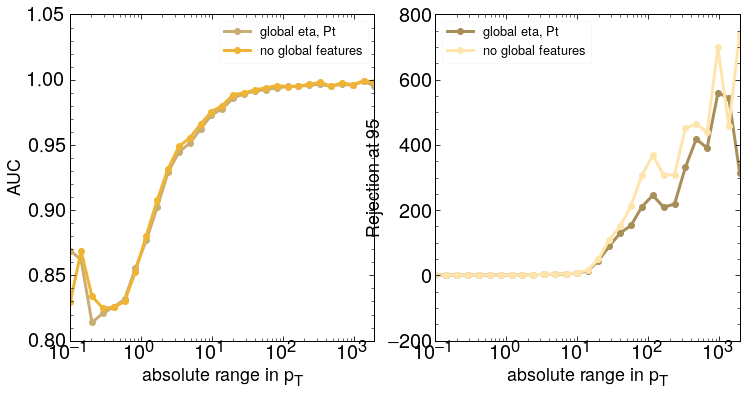

In [75]:
plots1(Pt_range, auc_pt_pt[:-1], auc_ng_pt[:-1], reg95_pt_Pt[:-1], reg95_ng_Pt[:-1], rangename='$p_T$', globalpars='eta, Pt', logx=True)

<ipython-input-70-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)


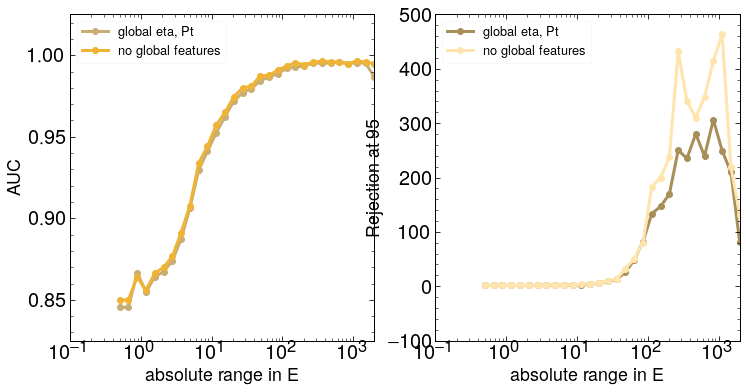

In [76]:
plots1(E_range, auc_pt_E[:-1], auc_ng_E[:-1], reg95_pt_E[:-1], reg95_ng_E[:-1], rangename='E', globalpars='eta, Pt', logx=True)

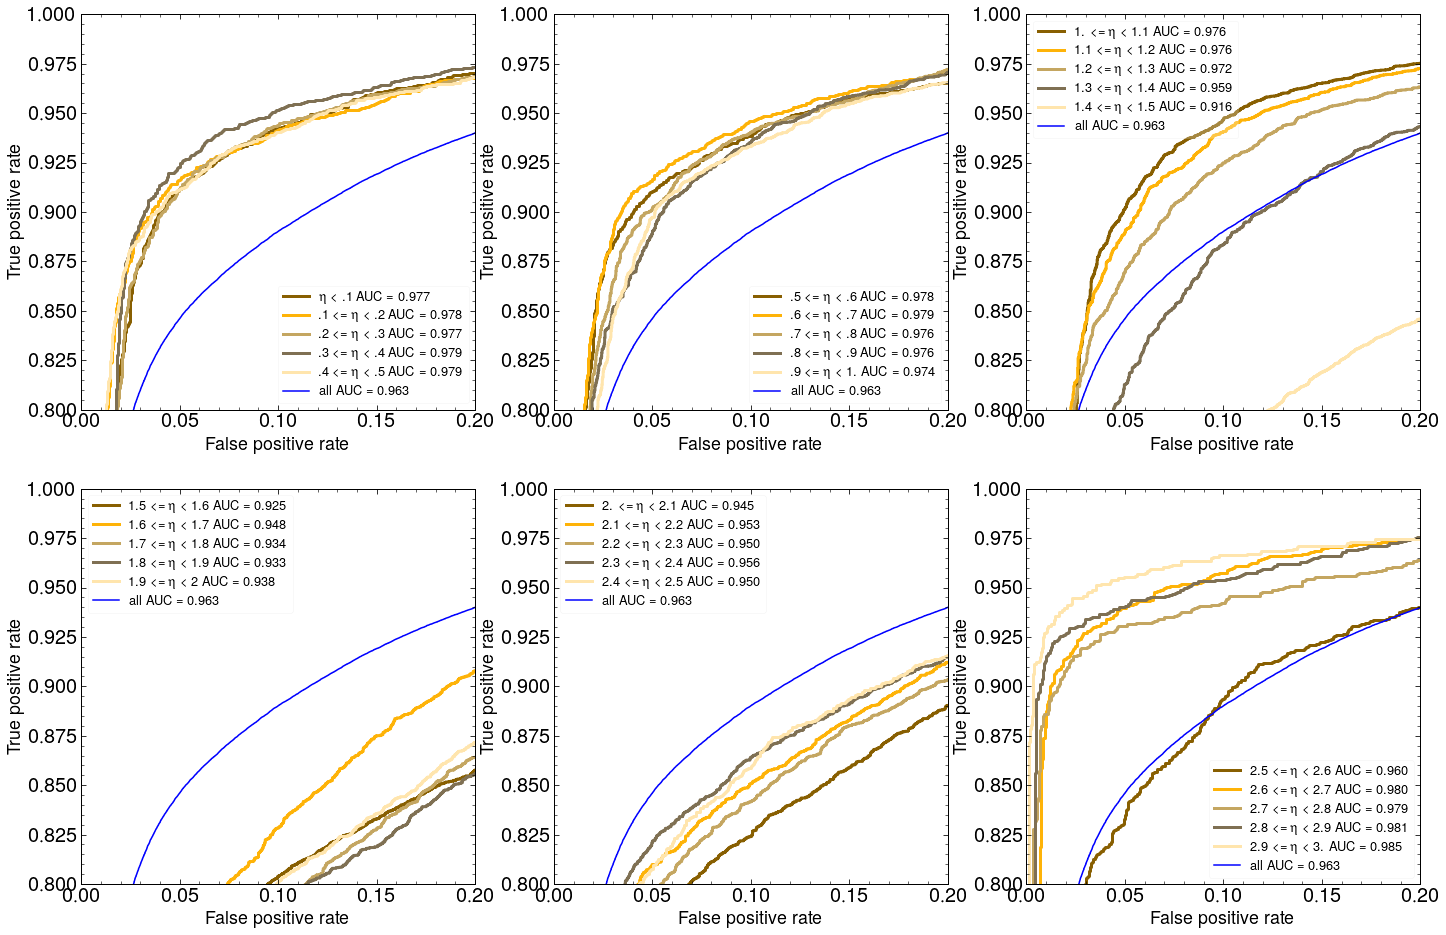

In [61]:
AUCplot(eta_ranges, fps_pt_eta, tps_pt_eta, auc_pt_eta, rangetype='eta')

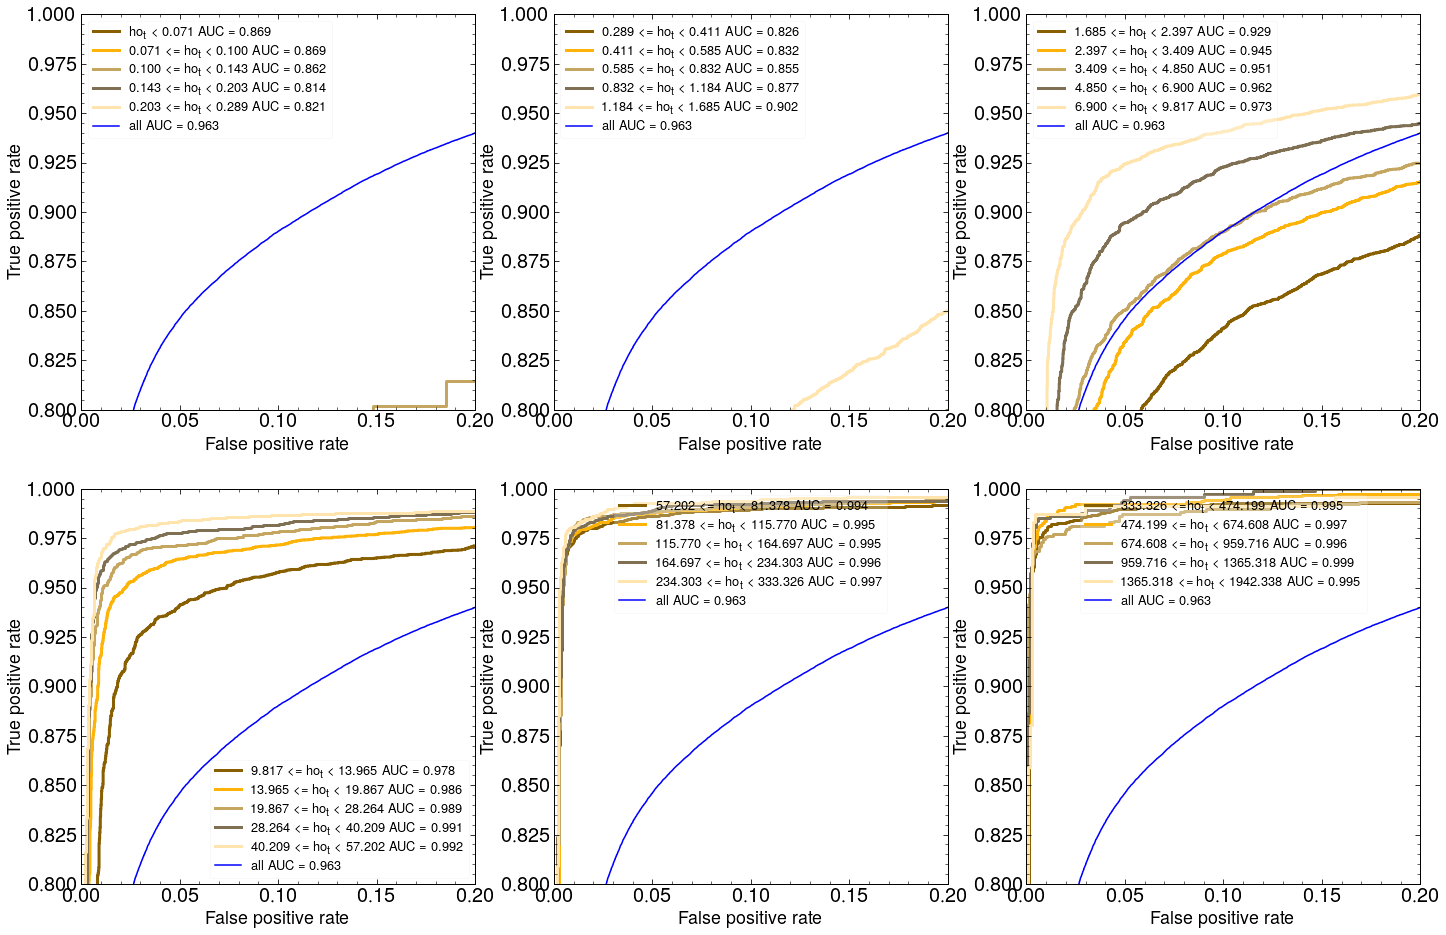

In [63]:
AUCplot(Pt_range, fps_pt_pt, tps_pt_pt, auc_pt_pt, rangetype='Pt')

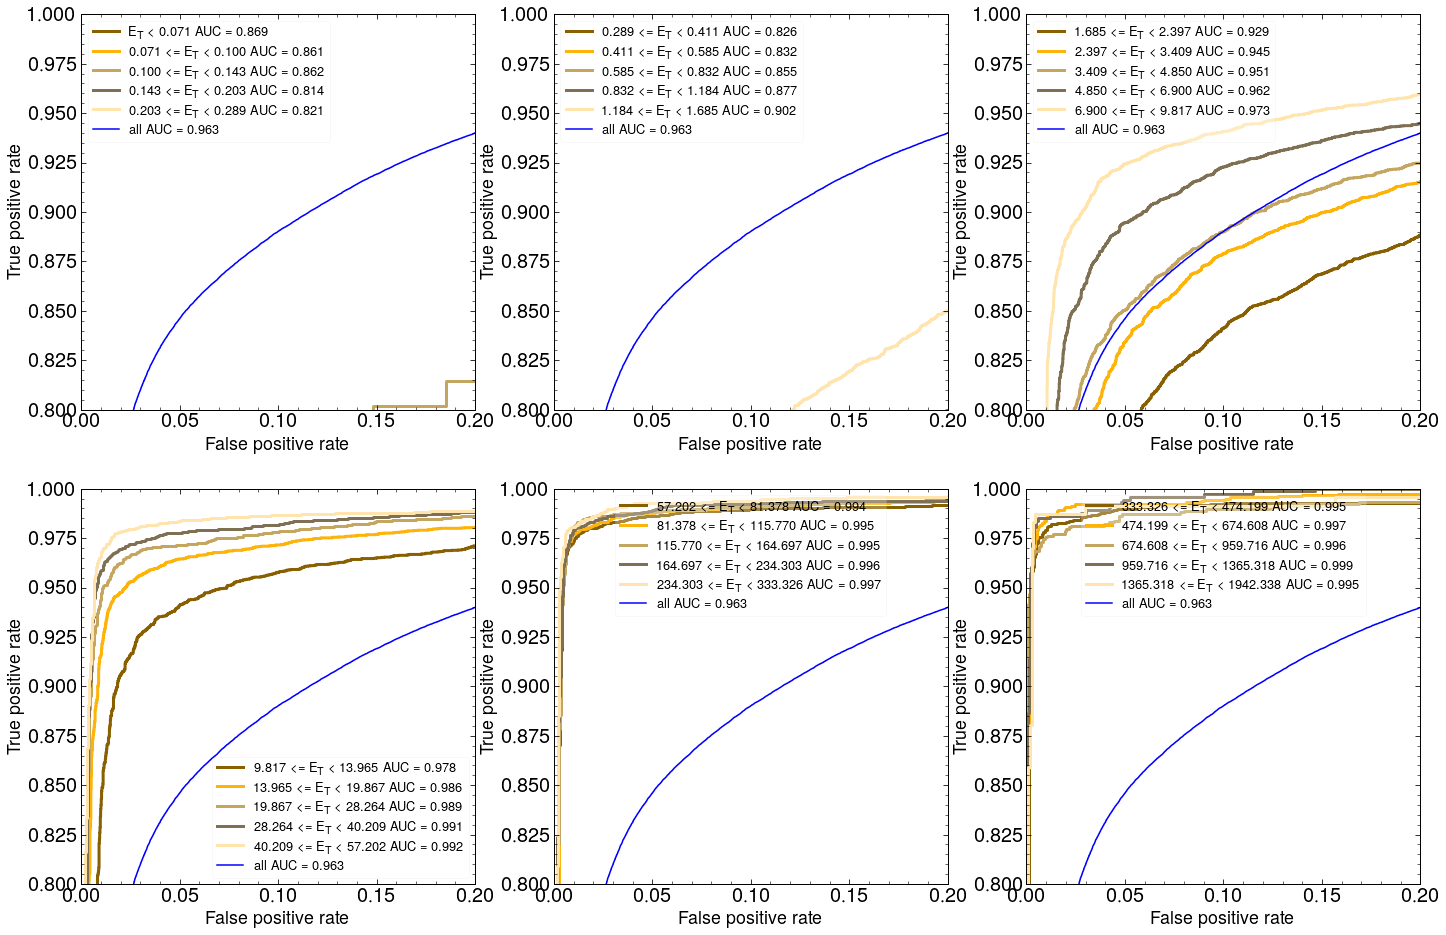

In [64]:
AUCplot(ET_range, fps_pt_ET, tps_pt_ET, auc_pt_ET, rangetype='E_T')

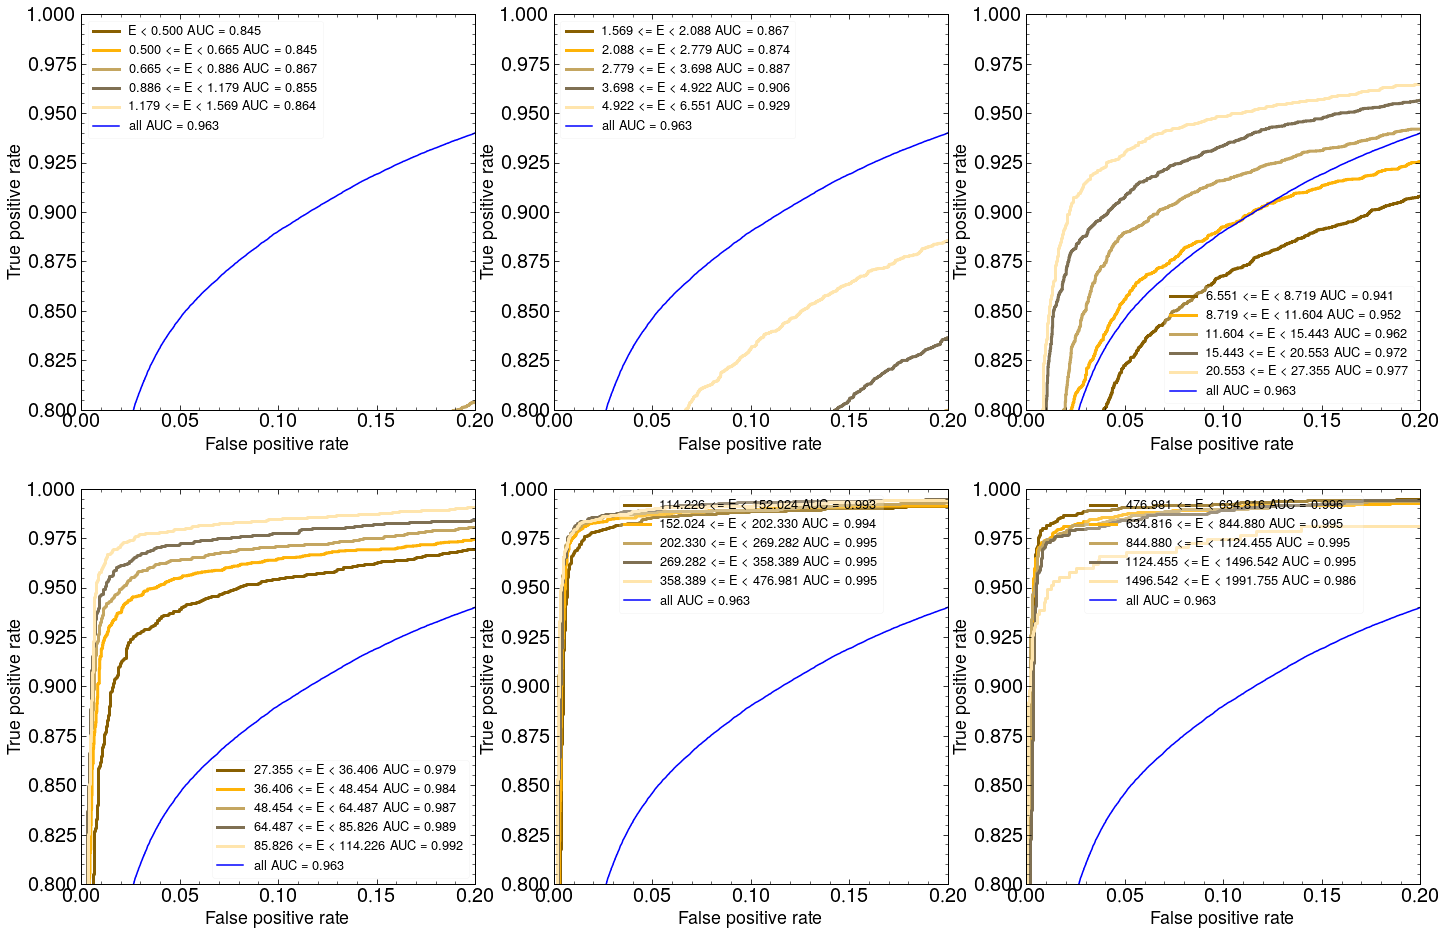

In [65]:
AUCplot(E_range, fps_pt_E, tps_pt_E, auc_pt_E, rangetype='E')

<ipython-input-70-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)


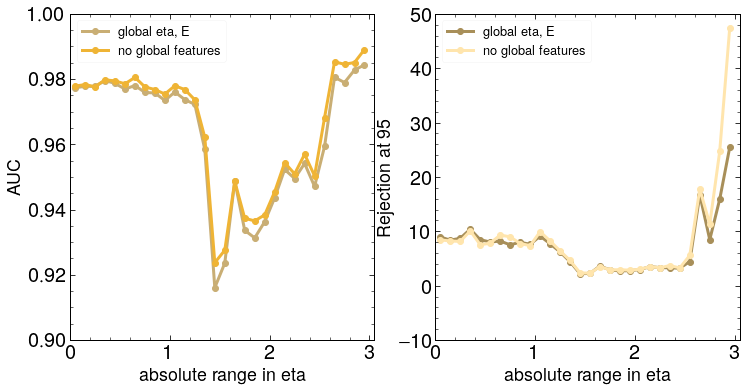

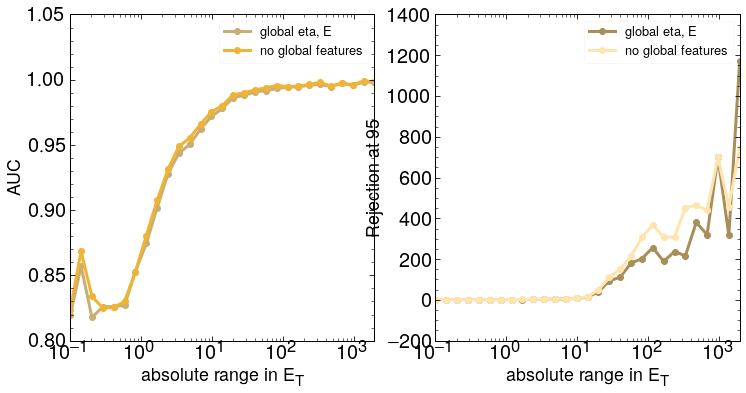

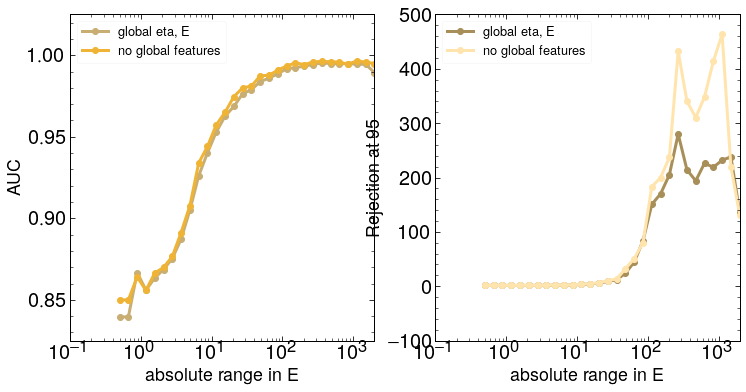

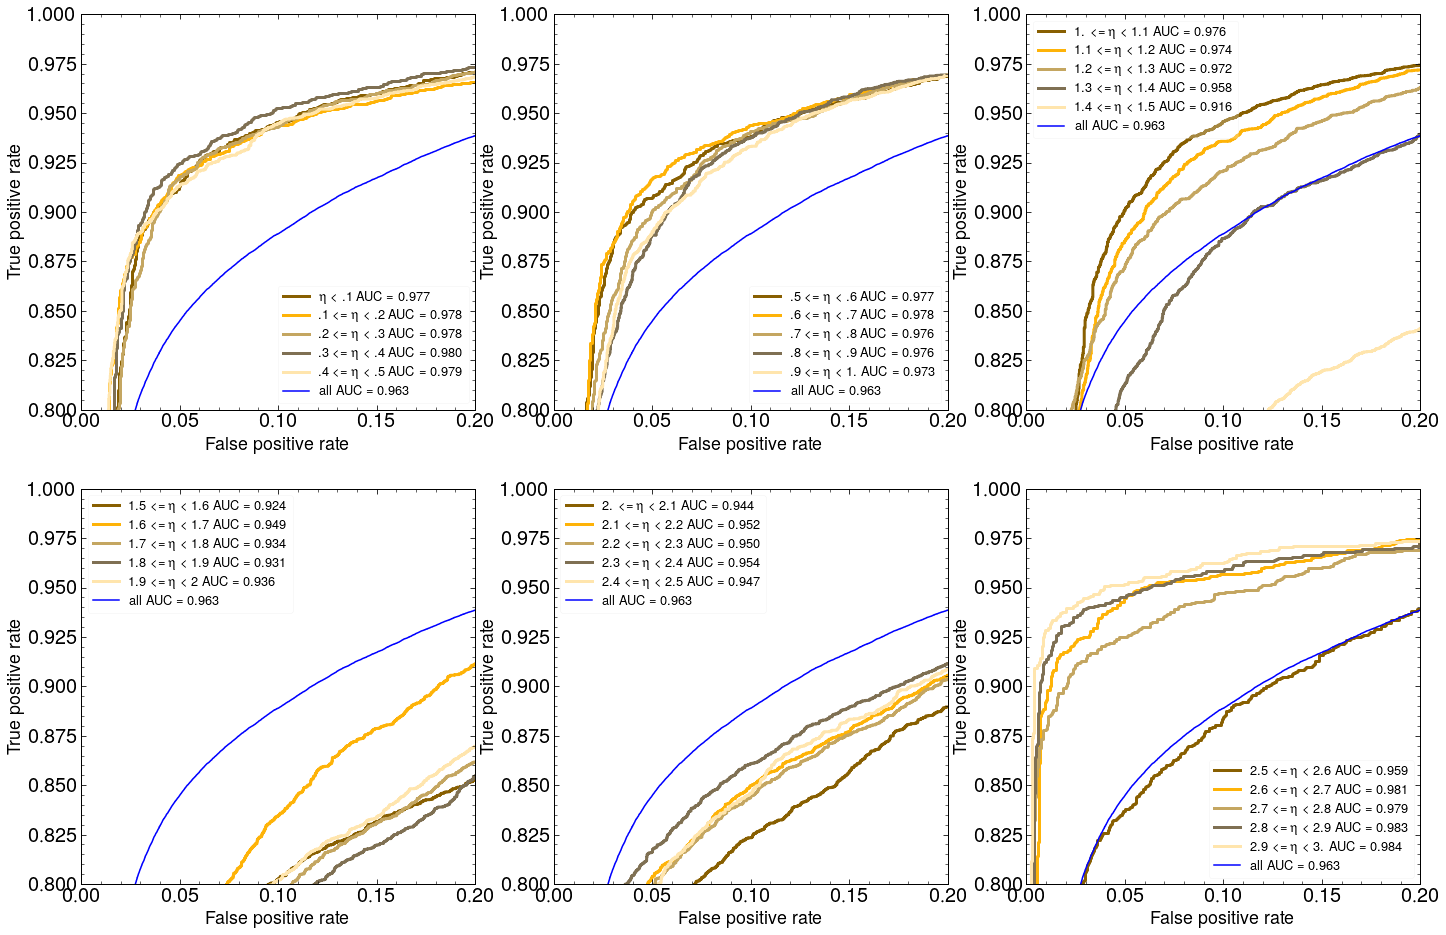

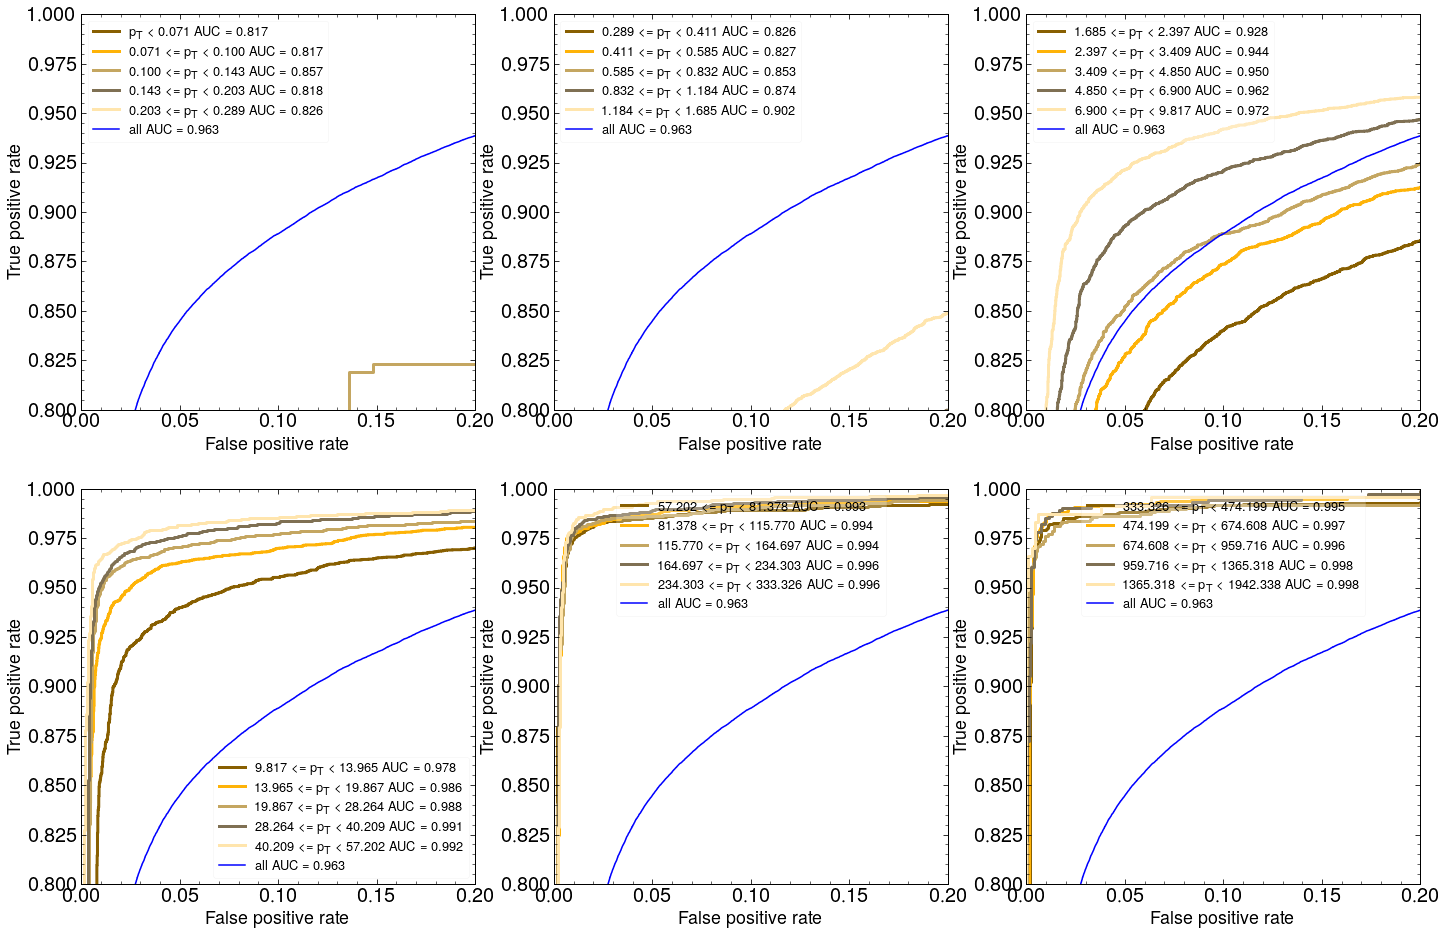

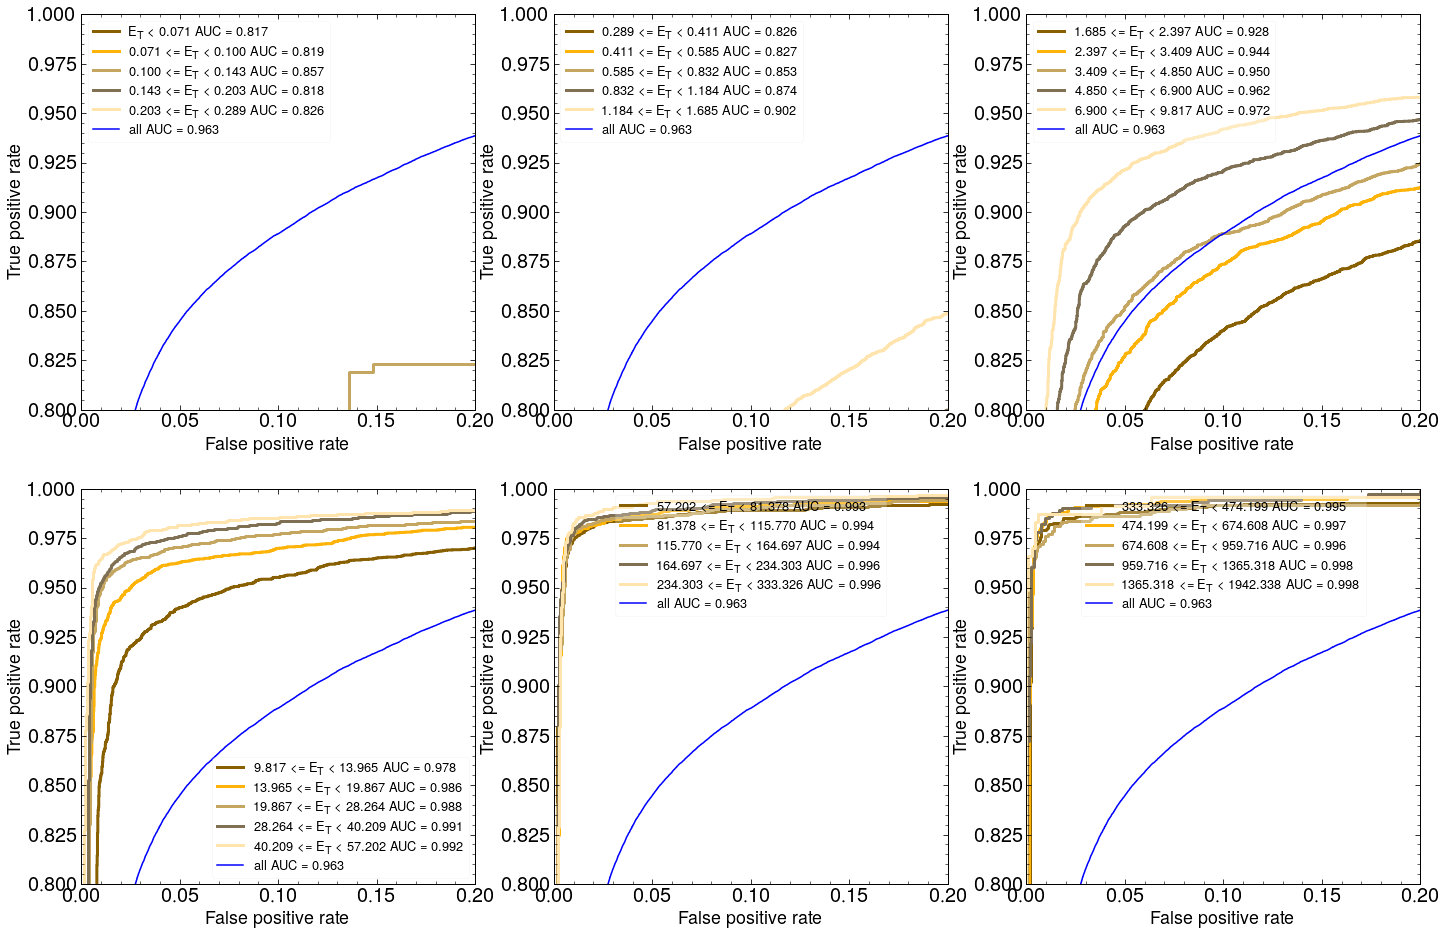

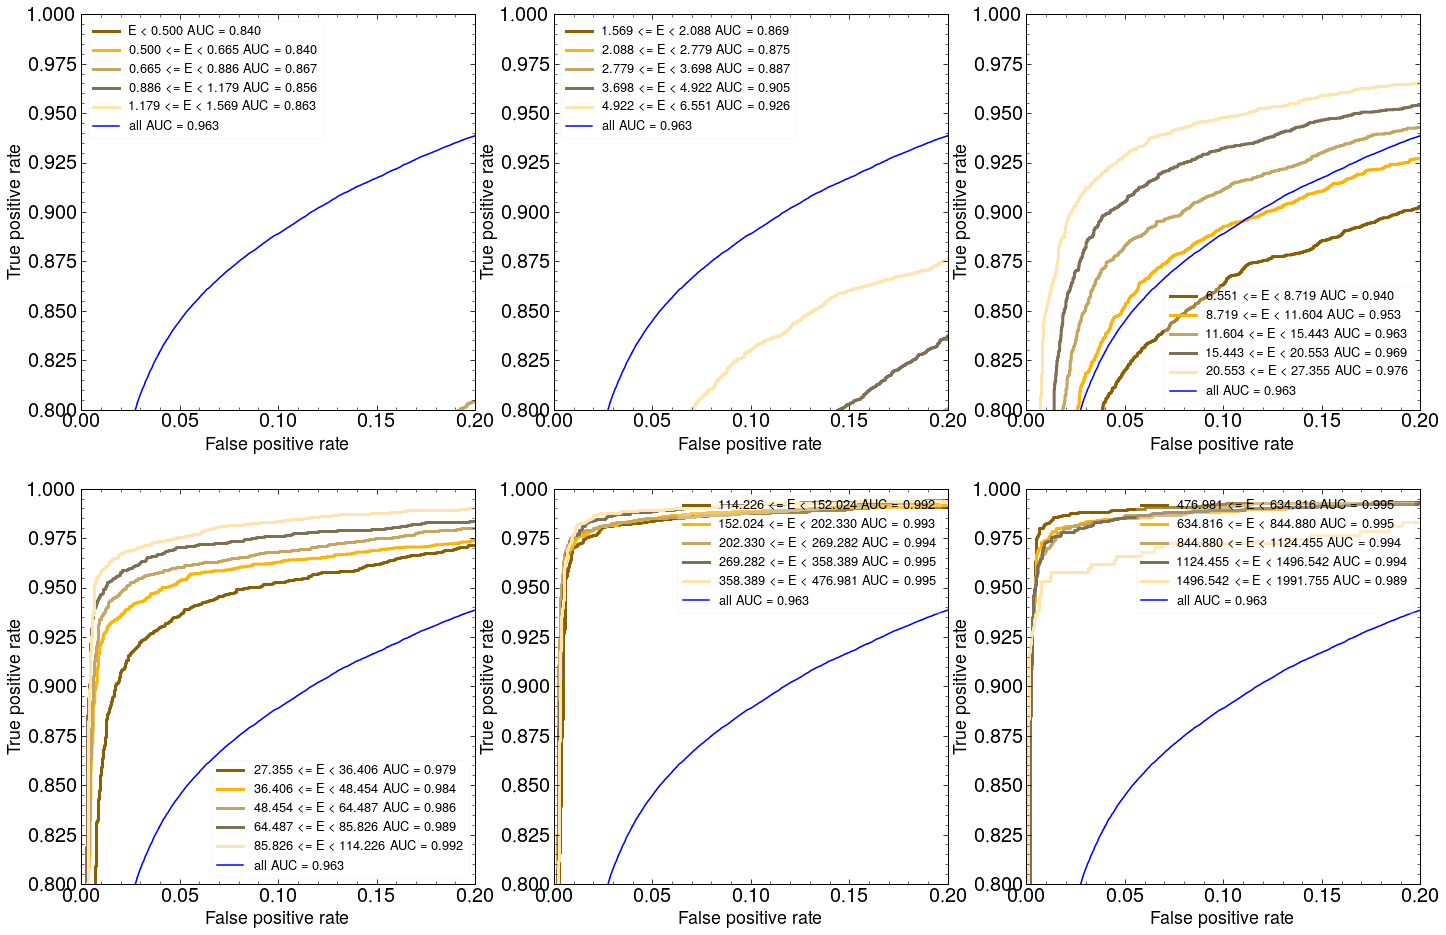

In [77]:
#now for E:
plots1(eta_ranges[:-1], auc_E_eta[:-1], auc_ng_eta[:-1], reg95_E_eta[:-1], reg95_ng_eta[:-1], rangename='eta', globalpars='eta, E')
plots1(ET_range, auc_E_ET[:-1], auc_ng_ET[:-1], reg95_E_ET[:-1], reg95_ng_ET[:-1], rangename='$E_T$', globalpars='eta, E', logx=True)
plots1(E_range, auc_E_E[:-1], auc_ng_E[:-1], reg95_E_E[:-1], reg95_ng_E[:-1], rangename='E', globalpars='eta, E', logx=True)

AUCplot(eta_ranges, fps_E_eta, tps_E_eta, auc_E_eta, rangetype='eta')
AUCplot(Pt_range, fps_E_pt, tps_E_pt, auc_E_pt, rangetype='Pt')
AUCplot(ET_range, fps_E_ET, tps_E_ET, auc_E_ET, rangetype='E_T')
AUCplot(E_range, fps_E_E, tps_E_E, auc_E_E, rangetype='E')